[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ignacio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Ignacio\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5005592841163311
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66      1788
           1       0.51      0.03      0.06      1788

    accuracy                           0.50      3576
   macro avg       0.50      0.50      0.36      3576
weighted avg       0.50      0.50      0.36      3576

Improved predictions saved to REAL_DATA_Predictions_Improved.csv


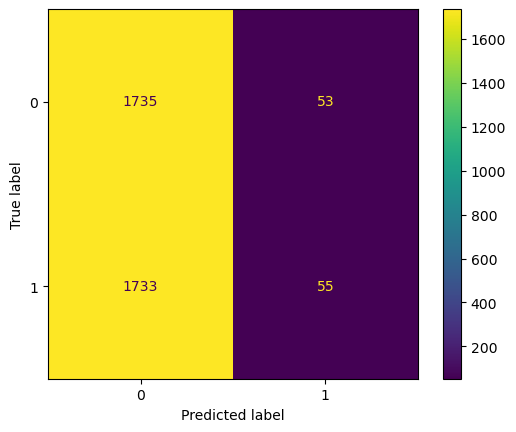

In [5]:
# Import necessary libraries
import pandas as pd
import re
import unicodedata
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from nltk.corpus import stopwords
import nltk
from imblearn.over_sampling import SMOTE

# Download Spanish stopwords
nltk.download("stopwords")
spanish_stop_words = stopwords.words("spanish")
additional_stop_words = ["usted", "un", "una", "este", "esta"]
spanish_stop_words.extend(additional_stop_words)

# Function to preprocess text
def preprocess_text(text):
    # Remove accents
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    return text.strip()

# Function to load training data
def load_training_data(file_path):
    sentences = []
    labels = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            parts = line.split("\t")
            if len(parts) == 2:
                sentences.append(preprocess_text(parts[1].strip()))
                labels.append(int(parts[0]))
    return sentences, labels

# Load and preprocess training data
training_file = "TRAINING_DATA.txt"
sentences, labels = load_training_data(training_file)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    sentences, labels, test_size=0.2, random_state=42, stratify=labels
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=20000, ngram_range=(1, 3), stop_words=spanish_stop_words, sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Hyperparameter tuning for XGBoost
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
}

grid_search = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Best model from GridSearchCV
best_clf = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()

# Function to load real data
def load_real_data(file_path):
    sentences = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            parts = line.split("\t")
            if len(parts) > 1:
                sentences.append(preprocess_text(parts[1].strip()))
            else:
                sentences.append(preprocess_text(line.strip()))
    return sentences

# Load real data
real_file = "REAL_DATA.txt"
real_sentences = load_real_data(real_file)

# Predict labels for real data
real_sentences_tfidf = vectorizer.transform(real_sentences)
real_predictions = best_clf.predict(real_sentences_tfidf)

# Save predictions to a CSV file
output = pd.DataFrame({"Sentence": real_sentences, "Prediction": real_predictions})
output.to_csv("REAL_DATA_Predictions_Improved.csv", index=False, encoding="utf-8")
print("Improved predictions saved to REAL_DATA_Predictions_Improved.csv")
